In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
np.random.seed(0)
# import seaborn as sns
# sns.set_theme(context='notebook')
# sns.reset_orig()

<h3> In this exercise, you are required to implement Gaussian Mixtures for Soft Clustering using the Expectation Maximization (EM) Algorithm. We will use the same data as the one from the K-Means exercise.

<h3> 1. Initialize clusters by drawing randomly from a uniform distribution.

<h3> 2. Clearly specify the Expectation step and the Maximization step.

In [17]:
X = pd.read_csv('HTRU_2.csv').values

In [18]:
class GaussianMixtureModel:
    def __init__(self, n_clusters, max_iter=10, tol=1e-6):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.means = None
        self.covariances = None
        self.weights = None
        self.responsibilities = None
        self.log_likelihood = None
        
    def fit(self, X):
        n_samples, _ = X.shape
        # Initialize the means, covariances, and weights randomly
        self.means = X[np.random.choice(n_samples, self.n_clusters), :]
        self.covariances = [np.cov(X.T) for _ in range(self.n_clusters)]
        self.weights = np.ones(self.n_clusters) / self.n_clusters
        # Initialize the responsibilities of each sample to each cluster
        self.responsibilities = np.zeros((n_samples, self.n_clusters))
        # Initialize the log likelihood list
        self.log_likelihood = []

        # Repeat the expectation-maximization (EM) algorithm for the specified number of iterations
        for i in range(self.max_iter):
            # Expectation step
            for j in range(self.n_clusters):
                # Calculate the responsibilities of each sample to each cluster
                self.responsibilities[:, j] = self.weights[j] * multivariate_normal.pdf(X, mean=self.means[j], cov=self.covariances[j])
            # Normalize the responsibilities so they sum to 1 for each sample
            self.responsibilities /= np.sum(self.responsibilities, axis=1)[:, np.newaxis]
            # Maximization step
            for j in range(self.n_clusters):
                # Calculate the number of samples assigned to each cluster
                N_j = np.sum(self.responsibilities[:, j])
                # Calculate the new means of each cluster
                self.means[j] = 1 / N_j * np.sum(self.responsibilities[:, j][:, np.newaxis] * X, axis=0)
                # Center the data points around the new means
                X_centered = X - self.means[j]
                # Calculate the new covariance matrices for each cluster
                self.covariances[j] = 1 / N_j * np.dot(X_centered.T, X_centered * self.responsibilities[:, j][:, np.newaxis])
                # Calculate the new weights for each cluster
                self.weights[j] = N_j / n_samples
            # Compute the log-likelihood of the data given the current parameters
            log_likelihood = np.sum(np.log(np.sum(self.responsibilities, axis=1)))
            self.log_likelihood.append(log_likelihood)
            # Check for convergence by comparing the log-likelihood to the previous iteration
            if i > 0 and np.abs(log_likelihood - self.log_likelihood[-2]) < self.tol:
                break

    def predict(self, X):
        # Initialize the probability array with zeros
        probability = np.zeros((X.shape[0], self.n_clusters))
        # Loop through each cluster to calculate the probability of each sample belonging to the cluster
        for j in range(self.n_clusters):
            # Calculate the probability of each sample belonging to the cluster using the Gaussian distribution
            probability[:, j] = self.weights[j] * multivariate_normal.pdf(X, mean=self.means[j], cov=self.covariances[j])
        # Normalize the probabilities so that they add up to 1 for each sample
        probability /= np.sum(probability, axis=1)[:, np.newaxis]
        # Return the calculated probabilities
        return np.argmax(probability, axis=1)




<h3> 3. Plot, a figure showing the selection of the best number of clusters K


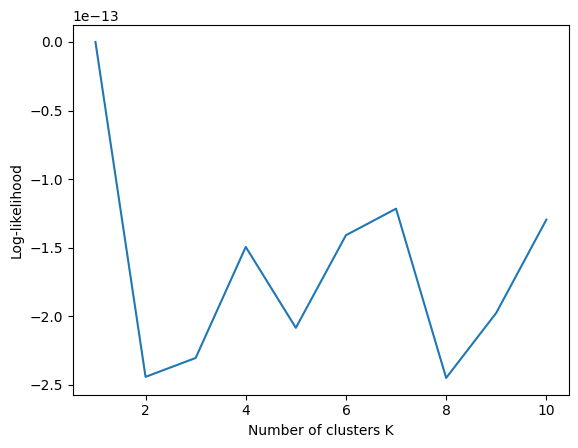

In [19]:
# Define the range for the number of clusters
k_min = 1
k_max = 10
# Initialize the list to store the log-likelihoods
scores = []
# Loop through the number of clusters
for K in range(k_min, k_max + 1):
    # Create an instance of the Gaussian Mixture Model with the specified number of clusters
    obj = GaussianMixtureModel(n_clusters=K)
    # Fit the Gaussian Mixture Model to the data
    obj.fit(X)
    # Append the final log-likelihood to the scores list
    scores.append(obj.log_likelihood[-1])
# Plot the number of clusters against the log-likelihoods
plt.plot(range(k_min, k_max + 1), scores)
plt.xlabel('Number of clusters K')
plt.ylabel('Log-likelihood')
plt.show()


<h3> 4. Plot the optimal cluster by assigning points to the cluster with the highest responsibility (Hard Clustering) using PCA.

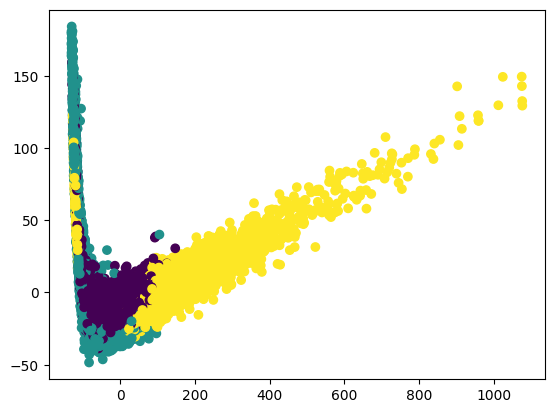

In [20]:
# instantiate GaussianMixtureModel object with n_clusters=3
obj = GaussianMixtureModel(n_clusters=3)
# fit the model to data X
obj.fit(X)
# Predict the probability of each sample belonging to each cluster
y_pred = obj.predict(X)
# Perform PCA to reduce the dimensionality of X to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
# Plot the scatter plot of X_pca with class labels defined by y_pred
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
# Show the plot
plt.show()